<a href="https://colab.research.google.com/github/Gab2697/Human-Activity-Recognition/blob/master/Test_Baseline.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Code description

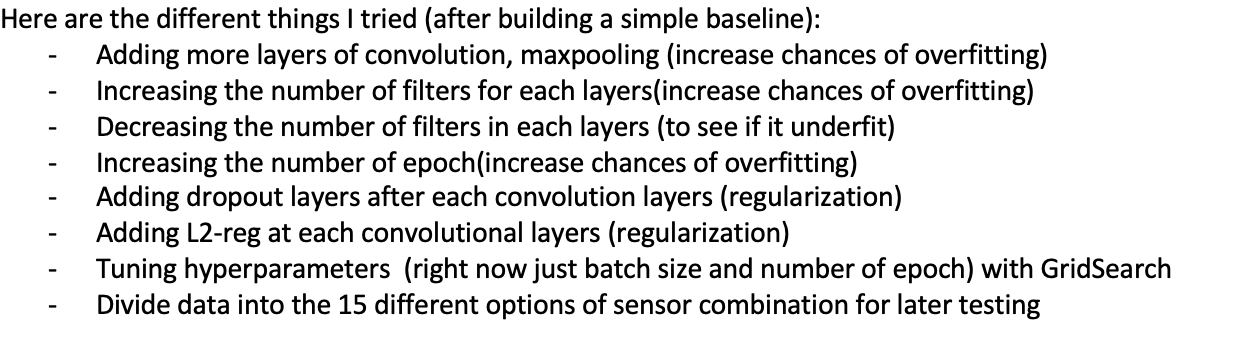

In [1]:
#import
import pandas as pd
import tensorflow as tf
import numpy as np
import os
import pickle
import matplotlib.pyplot as plt
from scipy import signal
import torch

from keras import layers 
from keras import models
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


#Load dataset

In [3]:
def open_pickle(path_pickle):
  f = open(path_pickle, 'rb')
  T = pickle.load(f)
  f.close()

  return T

In [4]:
#T13,T14,T15,T16,T17,T18,T19,T21,T22,T23,T25,T26,T27,T28
TTT=open_pickle('/content/drive/MyDrive/Gab/Variables_saved/TTT.pickle')
#T3,T4,T5,T7,T8,T9,T10,T11,T12,T20,T24
T=open_pickle('/content/drive/MyDrive/Gab/Variables_saved/TT.pickle')

#bring all into one
TT = tf.concat([T,TTT], axis=1)

TT.shape

TensorShape([7704, 3959, 6])

In [6]:
####need to train and test randomly
TT_shuffle_x=tf.random.shuffle(TT[:,:,0:4], seed=8)
TT_shuffle_y=tf.random.shuffle(TT[:,:,4], seed=8)


#========Initial cutting========
#X-data with shape ((1926frames x 4sec)x(80trials x 2surfaces x n-participants) x 4channels)
X=TT_shuffle_x.numpy() #size: (7704, 320, 4)
#Y-categorical encoded label = 1 for asphalt and 0 for grass 
y=TT_shuffle_y.numpy() 
#number trials
num_trials= TT.shape[1]

#========Sreshaping into the specific intut format========S 
#keras CNN is looking for X= (batch_size, height, width,depth)
X_reshape = X.reshape((num_trials,7704, 4, 1))
y=y.reshape((num_trials,7704,1))
print("Data shape:", X_reshape.shape) 
print("Label shape:", y.shape)

#========Splitting the data into training and testing sets========keep 4 participants for testing 
#data set for training and testing the model
train_size= int(0.8*num_trials) 
X_train= X_reshape[0:train_size,:,:,:]
X_test=X_reshape[train_size:num_trials,:,:,:]

#labels for train and test
y_train=y[0:train_size,:,:] 
y_test=y[train_size:num_trials,:,:]

# ========convert class vectors to binary class matrices========
label_train = to_categorical(y_train, 2)
label_test = to_categorical(y_test, 2)

#========only keeping one label for each trials========
#(instead of a complete vector of the same number)
label_train= label_train[:,0,:]
label_test=label_test[:,0,:]

print("Data shape train:",X_train.shape,"Data shape test:",X_test.shape,"Label shape train:",label_train.shape,"Label shape test:",label_test.shape)

Data shape: (3959, 7704, 4, 1)
Label shape: (3959, 7704, 1)
Data shape train: (3167, 7704, 4, 1) Data shape test: (792, 7704, 4, 1) Label shape train: (3167, 2) Label shape test: (792, 2)


#Baseline CNN

Training and testing model

In [14]:
def make_model_basic(input_size,filter_numb1,filter_numb2,filter_numb3,kernel_size):
    #Instantiating a small convnet
    model = models.Sequential()
    #filter size: 32, kenel of 3x3, input shape without the batch_size (one trial), padding= with zero padding
    model.add(layers.Conv2D(filter_numb1, kernel_size, activation='relu', input_shape=(input_size),padding='same')) 
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Conv2D(filter_numb2, kernel_size, activation='relu',padding='same'))
    model.summary()

    #Adding a classifier on top of the convnet
    model.add(layers.Flatten()) 
    model.add(layers.Dense(filter_numb3, activation='relu')) 
    model.add(layers.Dense(2, activation='sigmoid')) #last layer has 2 output options
    model.summary()
    return model

model=make_model_basic(X_train.shape[1:],32,64,64,(3,3))

# testing CNN model
num_trial_batch=20
model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['accuracy']) 
history= model.fit(X_train, label_train, epochs=3, batch_size=num_trial_batch,validation_split=0.1)   

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_8 (Conv2D)           (None, 7704, 4, 32)       320       
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 3852, 2, 32)      0         
 2D)                                                             
                                                                 
 conv2d_9 (Conv2D)           (None, 3852, 2, 64)       18496     
                                                                 
Total params: 18,816
Trainable params: 18,816
Non-trainable params: 0
_________________________________________________________________
Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_8 (Conv2D)           (None, 7704, 4, 32)       320       
                            

Visualization

In [ ]:
#confusion matrix
from sklearn.metrics import confusion_matrix
import itertools
import matplotlib.pyplot as plt
y_true=label_train 
res = tf.math.confusion_matrix(y_true,y_predict)

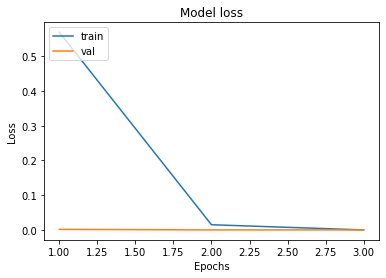

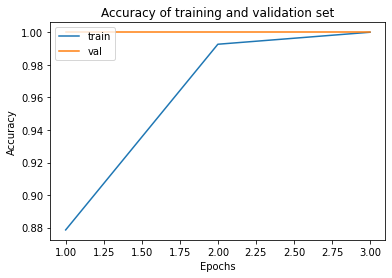

In [15]:
#plot train/validation loss and train/validation accuracy 
history_dict = history.history
loss_values=history_dict['loss']
epochs = range(1, len(loss_values) + 1)
plt.plot(epochs,history_dict['loss'])
plt.plot(epochs, history_dict['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

accuracy_values = history_dict['accuracy']
val_accuracy= history_dict['val_accuracy']
plt.plot(epochs, accuracy_values)
plt.plot(epochs, val_accuracy)
plt.title('Accuracy of training and validation set') 
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

#Testing Baseline

Add layers

In [21]:
    #Instantiating a small convnet
def make_model_layer(input_size,filter_numb1,filter_numb2,filter_numb3,filter_numb4,kernel_size):
    
      model = models.Sequential()
      #filter size: 32, kenel of 3x3, input shape without the batch_size (one trial), padding= with zero padding
      model.add(layers.Conv2D(filter_numb1, kernel_size, activation='relu', input_shape=(input_size),padding='same')) 
      model.add(layers.MaxPooling2D((2, 2)))
      #Add layer-------
      model.add(layers.Conv2D(filter_numb4, kernel_size, activation='relu',padding='same')) 
      model.add(layers.MaxPooling2D((2, 2)))
      model.add(layers.Conv2D(filter_numb2, kernel_size, activation='relu',padding='same'))
      model.summary()

      #Adding a classifier on top of the convnet
      model.add(layers.Flatten()) 
      model.add(layers.Dense(filter_numb3, activation='relu')) 
      model.add(layers.Dense(2, activation='sigmoid')) #last layer has 2 output options
      model.summary()
      return model

model=make_model_layer(X_train.shape[1:],32,64,64,32,(3,3))

# testing CNN model
num_trial_batch=100
model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['accuracy']) 
history= model.fit(X_train, label_train, epochs=5, batch_size=num_trial_batch,validation_split=0.1)   
 

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_10 (Conv2D)          (None, 7704, 4, 32)       320       
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 3852, 2, 32)      0         
 2D)                                                             
                                                                 
 conv2d_11 (Conv2D)          (None, 3852, 2, 32)       9248      
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 1926, 1, 32)      0         
 2D)                                                             
                                                                 
 conv2d_12 (Conv2D)          (None, 1926, 1, 64)       18496     
                                                                 
Total params: 28,064
Trainable params: 28,064
Non-trai

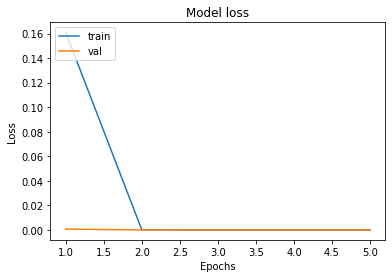

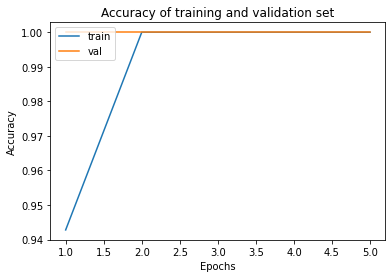

In [ ]:
#plot train/validation loss and train/validation accuracy 
history_dict = history.history
loss_values=history_dict['loss']
epochs = range(1, len(loss_values) + 1)
plt.plot(epochs,history_dict['loss'])
plt.plot(epochs, history_dict['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

accuracy_values = history_dict['accuracy']
val_accuracy= history_dict['val_accuracy']
plt.plot(epochs, accuracy_values)
plt.plot(epochs, val_accuracy)
plt.title('Accuracy of training and validation set') 
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

Directly in the function, we can test the impact of Bigger/smaller layers (more filters) and bigger/smaller filters to underfit and overfit the model.
We can also run the model we more or less epoch and different batch size (see the search grid section at the end for hyperparameter tuning)

#Regularization

Dropout

In [8]:
#Instantiating a small convnet
model = models.Sequential()
#filter size: 32, kenel of 3x3, input shape without the batch_size (one trial), padding= with zero padding
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(7704,4,1),padding='same')) 
model.add(layers.Dropout(0.5))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(32, (3, 3), activation='relu',padding='same'))
model.add(layers.Dropout(0.5)) 
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu',padding='same'))
model.add(layers.Dropout(0.5))
model.summary()


#Adding a classifier on top of the convnet
model.add(layers.Flatten()) 
model.add(layers.Dense(64, activation='relu')) 
model.add(layers.Dropout(0.5))
model.add(layers.Dense(2, activation='sigmoid')) #last layer has 2 output options
model.summary()

# testing CNN model
model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['accuracy']) 
history= model.fit(X_train, label_train, epochs=5, batch_size=50,validation_split=0.1)   

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 7704, 4, 32)       320       
                                                                 
 dropout (Dropout)           (None, 7704, 4, 32)       0         
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 3852, 2, 32)      0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 3852, 2, 32)       9248      
                                                                 
 dropout_1 (Dropout)         (None, 3852, 2, 32)       0         
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 1926, 1, 32)      0         
 2D)                                                  

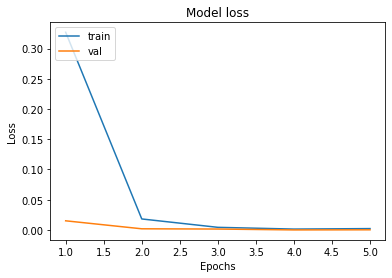

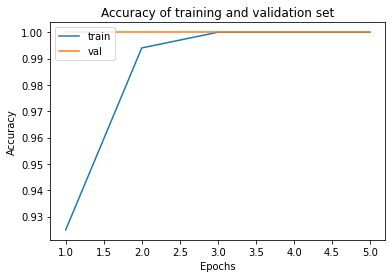

In [9]:
#plot train/validation loss and train/validation accuracy 
history_dict = history.history
loss_values=history_dict['loss']
epochs = range(1, len(loss_values) + 1)
plt.plot(epochs,history_dict['loss'])
plt.plot(epochs, history_dict['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

accuracy_values = history_dict['accuracy']
val_accuracy= history_dict['val_accuracy']
plt.plot(epochs, accuracy_values)
plt.plot(epochs, val_accuracy)
plt.title('Accuracy of training and validation set') 
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

Weight regularization-L2 (keeping also dropout)

In [22]:
from keras import regularizers

model = models.Sequential()
#filter size: 32, kenel of 3x3, input shape without the batch_size (one trial), padding= with zero padding
model.add(layers.Conv2D(32, (3, 3), kernel_regularizer=regularizers.l2(0.001), activation='relu', input_shape=(7704,4,1),padding='same')) 
model.add(layers.Dropout(0.5))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(32, (3, 3), kernel_regularizer=regularizers.l2(0.001),activation='relu',padding='same')) 
model.add(layers.Dropout(0.5))
model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.Conv2D(64, (3, 3), kernel_regularizer=regularizers.l2(0.001), activation='relu',padding='same'))
model.add(layers.Dropout(0.5))
model.summary()


#Adding a classifier on top of the convnet
model.add(layers.Flatten()) 
model.add(layers.Dense(64, kernel_regularizer=regularizers.l2(0.001), activation='relu')) 
model.add(layers.Dense(2, activation='sigmoid')) #last layer has 2 output options
model.summary()

# testing CNN model
model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['accuracy']) 
history= model.fit(X_train, label_train, epochs=3, batch_size=50,validation_split=0.2)  

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_7 (Conv2D)           (None, 7704, 4, 32)       320       
                                                                 
 dropout_3 (Dropout)         (None, 7704, 4, 32)       0         
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 3852, 2, 32)      0         
 2D)                                                             
                                                                 
 conv2d_8 (Conv2D)           (None, 3852, 2, 32)       9248      
                                                                 
 dropout_4 (Dropout)         (None, 3852, 2, 32)       0         
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 1926, 1, 32)      0         
 2D)                                                  

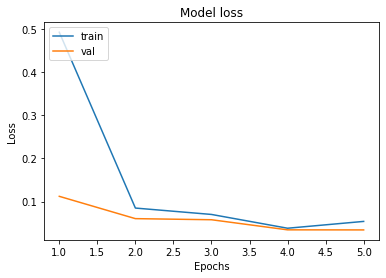

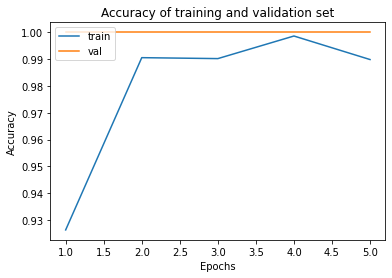

In [12]:
#plot train/validation loss and train/validation accuracy 
history_dict = history.history
loss_values=history_dict['loss']
epochs = range(1, len(loss_values) + 1)
plt.plot(epochs,history_dict['loss'])
plt.plot(epochs, history_dict['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

accuracy_values = history_dict['accuracy']
val_accuracy= history_dict['val_accuracy']
plt.plot(epochs, accuracy_values)
plt.plot(epochs, val_accuracy)
plt.title('Accuracy of training and validation set') 
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

#Tuning hyper parameters

In [ ]:
# Use scikit-learn to grid search the batch size and epochs
import numpy
from sklearn.model_selection import GridSearchCV
from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasClassifier
from keras import regularizers

# Function to create model, required for KerasClassifier
def create_model():
    model = models.Sequential()
    #filter size: 32, kenel of 3x3, input shape without the batch_size (one trial), padding= with zero padding
    model.add(layers.Conv2D(32, (3, 3), kernel_regularizer=regularizers.l2(0.001), activation='relu', input_shape=(7704,4,1),padding='same')) 
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Conv2D(32, (3, 3), kernel_regularizer=regularizers.l2(0.001),activation='relu',padding='same')) 
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Conv2D(64, (3, 3), kernel_regularizer=regularizers.l2(0.001), activation='relu',padding='same'))

    #Adding a classifier on top of the convnet
    model.add(layers.Flatten()) 
    model.add(layers.Dense(64, kernel_regularizer=regularizers.l2(0.001), activation='relu')) 
    model.add(layers.Dense(2, activation='sigmoid')) #last layer has 2 output options

    # testing CNN model
    opt = tf.keras.optimizers.RMSprop(learning_rate=0.01)
    model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy']) 

    return model
# fix random seed for reproducibility
seed = 7
numpy.random.seed(seed)

# create model
model = KerasClassifier(build_fn=create_model, verbose=0)
# define the grid search parameters
batch_size = [20, 40, 50, 100] 
epochs = [5,10,15,20]
param_grid = dict(batch_size=batch_size, epochs=epochs)
grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1, cv=3)
grid_result = grid.fit(X_train, label_train) #validation_split=0.1
# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead.
/usr/local/lib/python3.7/dist-packages/joblib/externals/loky/process_executor.py:705: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


Best: 0.982422 using {'batch_size': 40, 'epochs': 15}
0.655934 (0.214509) with: {'batch_size': 10, 'epochs': 5}
0.501938 (0.009049) with: {'batch_size': 10, 'epochs': 10}
0.812831 (0.231591) with: {'batch_size': 10, 'epochs': 15}
0.663731 (0.233670) with: {'batch_size': 10, 'epochs': 20}
0.783500 (0.210814) with: {'batch_size': 20, 'epochs': 5}
0.661782 (0.222773) with: {'batch_size': 20, 'epochs': 10}
0.503887 (0.008398) with: {'batch_size': 20, 'epochs': 15}
0.666632 (0.223299) with: {'batch_size': 20, 'epochs': 20}
0.507809 (0.004965) with: {'batch_size': 40, 'epochs': 5}
0.808898 (0.216369) with: {'batch_size': 40, 'epochs': 10}
0.982422 (0.004775) with: {'batch_size': 40, 'epochs': 15}
0.659833 (0.228158) with: {'batch_size': 40, 'epochs': 20}
0.957023 (0.005580) with: {'batch_size': 60, 'epochs': 5}
0.820628 (0.228786) with: {'batch_size': 60, 'epochs': 10}
0.771850 (0.198468) with: {'batch_size': 60, 'epochs': 15}
0.645121 (0.213622) with: {'batch_size': 60, 'epochs': 20}
0.6019

#Different combination of channels

In [ ]:
#--------#COMBINATION OF 4#--------#
#Option 1: ALL 4
X_train=X_train

#--------#COMBINATION OF 1#--------#
#Option 2: Only TA
X_train=X_train[0]
#Option 3: Only Gastroc
X_train=X_train[1]
#Option 4: Only RF
X_train=X_train[2]
#Option 5: Only BF
X_train=X_train[3]

#--------#COMBINATION OF 2#--------#
#Option 6: TA,Gastroc
X_train=X_train[0:1]
#Option 7: TA,RF
X_train=X_train[0:2:2]
#Option 8: TA,BF
X_train=X_train[0:3:3]
#Option 9: Gastroc,RF
X_train=X_train[1:2]
#Option 10: Gastroc,BF
X_train=X_train[1:3:2]
#Option 11: RF,BF
X_train=X_train[2:3]

#--------#COMBINATION OF 3#--------#
#Option 12: TA,Gastroc, RF
X_train=X_train[0:2]
#Option 13: TA,Gastroc, BF
X_train=X_train[0:1]+X_train[3]####not sure how to do this####-----------------------
#Option 14: TA,RF, BF
X_train=X_train[0]+X_train[2:3]####not sure how to do this####-----------------------
#Option 15: Gastroc, RF,BF
X_train=X_train[1:3]